# Creating escarpment morphology 'grid' that can be extracted as netCDF files

In [1]:
import os
import pygmt
import meshio
import meshplex
import numpy as np
import xarray as xr
from scipy import spatial
from scripts import isinside
from gospl._fortran import definegtin, gfill

### Defining a square grid (extent) and resolution 

In [2]:
res = 250. # meters

xsize = 100000. # 100 km
ysize = 200000. # 200 km

xrange = np.arange(0,xsize+1,res) 
yrange = np.arange(0,ysize+1,res) 

bbox = [xrange[0], yrange[0], xrange[-1], yrange[-1]]

### Creating initial elevations of LEM

In [3]:
# Creating grid for reference simulation (a)
flatGrid = np.zeros((len(yrange),len(xrange)))
flatGrid[160:,:]= 1000

# Example for other LEMs. Creating grid for linear drainage basin LEMs (i and j)
# flatGrid = np.zeros((len(yrange),len(xrange)))
# flatGrid[160:,:]= 1000
# slp = 500/(801-idRow)
# for k in range(idRow,801):
#     flatGrid[k,:] = flatGrid[k-1,:] - slp

Combine dataset

In [4]:
grid_da = xr.DataArray(
    flatGrid,
    coords = [yrange,xrange],
    dims = ["y","x"]
)

dataset = xr.Dataset({'elev':grid_da},)

dataset

<xarray.Dataset>
Dimensions:  (y: 801, x: 401)
Coordinates:
  * y        (y) float64 0.0 250.0 500.0 750.0 ... 1.995e+05 1.998e+05 2e+05
  * x        (x) float64 0.0 250.0 500.0 750.0 ... 9.95e+04 9.975e+04 1e+05
Data variables:
    elev     (y, x) float64 0.0 0.0 0.0 0.0 0.0 ... 1e+03 1e+03 1e+03 1e+03

### Create Map of landscapce morphology

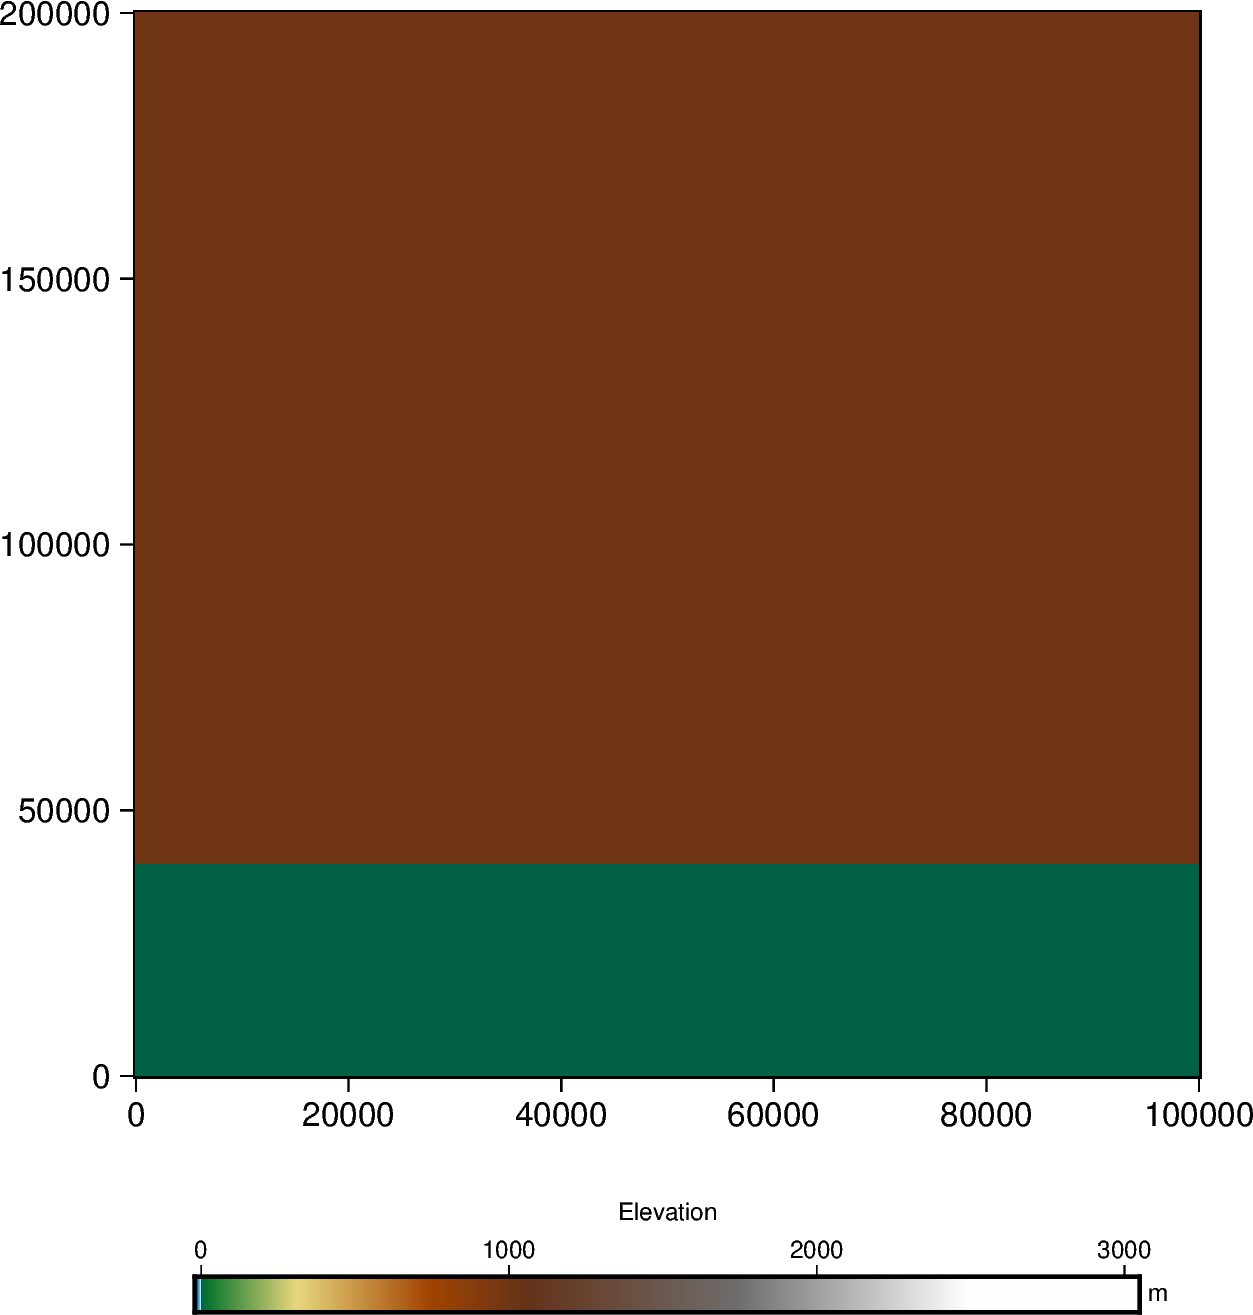

In [5]:
fig = pygmt.Figure()
with pygmt.config(FONT='8p,Helvetica,black'):
    pygmt.makecpt(cmap="geo", series=[-20, 3050]) 
    fig.basemap(
        region=[dataset.x.values.min(),dataset.x.values.max(),dataset.y.values.min(),dataset.y.values.max()],
        frame=['a'],
        projection="X9c",
    )
    fig.grdimage(dataset.elev, shading=False, frame=False)
    fig.colorbar(frame=["a1000", "x+lElevation", "y+lm"], position="jBC+o0c/-2c+w8c/0.3c+h") 
fig.show()

## Creating mesh

The input file (input_escarpment.yml) will also be provided separately.

In [6]:
res = 250.

# name of the folder where the inputs would be stored
mesh_path = 'inputs'
if not os.path.exists(mesh_path):
    os.makedirs(mesh_path)

# elevation mesh
elevfname = mesh_path+"/willet62"

## Interpolating Mesh

In [7]:
rx = dataset.x.values
ry = dataset.y.values
rx, ry = np.meshgrid(dataset.x.values,dataset.y.values)
rPts = np.stack((rx.ravel(), ry.ravel())).T
rshape = rx.shape


pts2D, cells = isinside.delaunayMesh(bbox, res)

# Create kdtree...
tree = spatial.cKDTree(rPts)
distances, indices = tree.query(pts2D, k=3)

# Inverse weighting distance...
weights = np.divide(
    1.0, distances ** 2, out=np.zeros_like(distances), where=distances != 0
)
sumweights = np.sum(weights, axis=1)

onIDs = np.where(sumweights == 0)[0]
sumweights[sumweights == 0] = 1.0e-4

# data to interpolate
elev = dataset.elev.values.flatten()
zMesh = np.sum(weights * elev[indices][:, :], axis=1) / sumweights
if len(onIDs)>0:
    zMesh[onIDs] = elev[indices[onIDs,0]]
    
coords = np.zeros((len(zMesh),3))
coords[:,:2] = pts2D

# Set meshplex triangular mesh
Gmesh = meshplex.MeshTri(coords, cells)
s = Gmesh.idx_hierarchy.shape
a = np.sort(Gmesh.idx_hierarchy.reshape(s[0], -1).T)
Gmesh.edges = {"points": np.unique(a, axis=0)}

# Get each vertice neighbours indices
_, Ngbs = definegtin(len(coords), cells, Gmesh.edges["points"])

# Remove small pits (below 10 m depth) 
fillz = gfill(-3000., zMesh, Ngbs, 10.)

np.savez_compressed(elevfname, v=coords, c=cells, 
                    n=Ngbs[:, :8].astype(int), z=fillz)

## VTK check in Paraview (to ensure files can be read/viewed in a different program)

In [8]:
vtk = "test.vtk"

# Define mesh
vis_mesh = meshio.Mesh(coords, {"triangle": cells}, 
                       point_data={"elev": fillz}) #, "rain": rMesh})
# "tecto": tMesh this goes after "elev": fillz, 
# Write it disk
meshio.write(vtk, vis_mesh)

print("Writing VTK input file as {}".format(vtk))

Writing VTK input file as test.vtk
